<a target="_blank" href="https://colab.research.google.com/github/alexmelekhin/iprofihack2023_place_recognition/blob/dev/baseline_demo.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Установка в Google Colab

Ячейки ниже рекомендуется использовать для установки зависимостей в Google Colab.

1. Убедитесь, что вы подключены к окружению с GPU

In [ ]:
!nvidia-smi

2. По умолчанию установлена версия torch 2.0, нам нужно откатиться до 1.13.1 (код не тестировался на версии 2.0 и может вести себя непредсказуемо)

In [ ]:
!pip install torch==1.13.1 torchvision==0.14.1

In [ ]:
import torch
print(f"torch version: {torch.__version__}")
print(f"Is CUDA available in torch?: {torch.cuda.is_available()}")

3. Установка необходимых библиотек для сборки MinkowskiEngine

In [ ]:
!pip install ninja

In [ ]:
!sudo apt-get install libopenblas-dev

4. Сборка и установка MinkowskiEngine из исходников (занимает много времени)

In [ ]:
!pip install -U git+https://github.com/NVIDIA/MinkowskiEngine -v --no-deps \
                          --install-option="--force_cuda" \
                          --install-option="--blas=openblas"

5. Проверка, что все работает

In [ ]:
import torch
print(f"Is CUDA available in torch?: {torch.cuda.is_available()}")
import MinkowskiEngine as ME
print(f"Is CUDA available in MinkowskiEngine?: {ME.is_cuda_available()}")
ME.print_diagnostics()

6. Финальный шаг - установка библиотеки [opr](https://github.com/alexmelekhin/open_place_recognition), код из которой будет использоваться в бейзлайне

In [ ]:
!git clone https://github.com/alexmelekhin/open_place_recognition
%cd open_place_recognition
!pip install -e .  # флаг -e необходим для возможности редактировать код уже установленной библиотеки
%cd ..

## Загрузка датасета в Google Colab

Пример кода для загрузки датасета.

Вы можете воспользоваться утилитой gdown, которая по умолчанию доступна в Colab. Допустим, https://drive.google.com/file/d/1EdOTVgBJxsNUMecne7Fs4obJdJnDuJ18/view?usp=share_link - ссылка на файл. Чтобы скачать его, нам нужно передать в gdown в качестве аргумента его id - для данного примера это `1EdOTVgBJxsNUMecne7Fs4obJdJnDuJ18` (часть ссылки между `file/d/` и `/view`).

In [ ]:
!gdown 1EdOTVgBJxsNUMecne7Fs4obJdJnDuJ18

Вы можете сверить хэш-сумму файла:

In [ ]:
!sha256sum public.zip

И распаковать архив:

In [ ]:
!unzip -q public.zip

## Базовое решение

Загрузите веса MinkLoc++, предобученного на датасете Oxford RobotCar по ссылке: https://drive.google.com/file/d/1zlfdX217Nh3_QL5r0XAHUjDFjIPxUmMg/view?usp=share_link

In [1]:
from opr.models import minkloc_multimodal

model = minkloc_multimodal(weights="baseline_minkloc_multimodal.pth")

/home/docker_hackathon/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pathlib import Path

EPOCHS = 10

IMAGE_LR = 0.0001
CLOUD_LR = 0.001
FUSION_LR = 0.001
WEIGHT_DECAY = 0.0001

SCHEDULER_GAMMA = 0.1
SCHEDULER_STEPS = [5]

DEVICE = "cuda"
BATCH_EXPANSION_TH = None
CHECKPOINTS_DIR = Path("checkpoints")


Для инициализации функции лосса предлагается воспользоваться средствами библиотеки [Hydra](https://hydra.cc/docs/intro/).

Примеры готовых конфиг-файлов есть в директории "configs" [репозитория opr](https://github.com/alexmelekhin/open_place_recognition). Обратите внимание, что в конфигурации датасета необходимо указать путь к его директории.

In [3]:
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR

from hydra.utils import instantiate
from omegaconf import OmegaConf

from opr.datasets.dataloader_factory import make_dataloaders


loss_cfg = OmegaConf.load("/home/docker_hackathon/Workspace/open_place_recognition/configs/losses/triplet_margin.yaml")
loss_fn = instantiate(loss_cfg)

dataset_cfg = OmegaConf.load("/home/docker_hackathon/Workspace/open_place_recognition/configs/datasets/phystech_campus.yaml")
dataloaders = make_dataloaders(
    dataset_cfg=dataset_cfg.dataset,
    batch_sampler_cfg=dataset_cfg.sampler,
    num_workers=dataset_cfg.num_workers,
)

params_list = []
if model.image_module is not None and IMAGE_LR is not None:
    params_list.append({"params": model.image_module.parameters(), "lr": IMAGE_LR})
if model.cloud_module is not None and CLOUD_LR is not None:
    params_list.append({"params": model.cloud_module.parameters(), "lr": CLOUD_LR})
if model.fusion_module is not None and FUSION_LR is not None:
    params_list.append({"params": model.fusion_module.parameters(), "lr": FUSION_LR})
optimizer = Adam(params_list, weight_decay=WEIGHT_DECAY)
scheduler = MultiStepLR(optimizer, milestones=SCHEDULER_STEPS, gamma=SCHEDULER_GAMMA)

if not CHECKPOINTS_DIR.exists():
    CHECKPOINTS_DIR.mkdir(parents=True)

model = model.to(DEVICE)

In [6]:
from opr.testing import test


recall_at_n, recall_at_one_percent, mean_top1_distance = test(
    model=model,
    descriptor_key="fusion",
    dataloader=dataloaders["test"],
    dist_thresh=5.0,
    device=DEVICE,
)

print(recall_at_n)

Calculating metrics: 100%|██████████| 6/6 [00:00<00:00,  8.02it/s]

Mean Recall@N:
[0.35832433 0.46075096 0.52536504 0.5618218  0.59198689 0.61640536
 0.63445118 0.65197783 0.67150134 0.68306623 0.69275496 0.70492458
 0.71186098 0.71967074 0.72547996 0.73210702 0.73955678 0.74756834
 0.75144274 0.75862737 0.76363231 0.77028684 0.77800951 0.78381246
 0.78966836]
Mean Recall@1% = 0.6164053595498168
Mean top-1 distance = 1.0901976143658783
[0.35832433 0.46075096 0.52536504 0.5618218  0.59198689 0.61640536
 0.63445118 0.65197783 0.67150134 0.68306623 0.69275496 0.70492458
 0.71186098 0.71967074 0.72547996 0.73210702 0.73955678 0.74756834
 0.75144274 0.75862737 0.76363231 0.77028684 0.77800951 0.78381246
 0.78966836]


In [7]:
print(recall_at_n)

[0.35832433 0.46075096 0.52536504 0.5618218  0.59198689 0.61640536
 0.63445118 0.65197783 0.67150134 0.68306623 0.69275496 0.70492458
 0.71186098 0.71967074 0.72547996 0.73210702 0.73955678 0.74756834
 0.75144274 0.75862737 0.76363231 0.77028684 0.77800951 0.78381246
 0.78966836]


In [10]:
private_dataset_cfg = OmegaConf.load("/home/docker_hackathon/Workspace/open_place_recognition/configs/datasets/phystech_campus_private.yaml")
private_dataloaders = make_dataloaders(private_dataset_cfg.dataset, private_dataset_cfg.sampler, private_dataset_cfg.num_workers)

recall_at_n, recall_at_one_percent, mean_top1_distance = test(
    model=model,
    descriptor_key="fusion",
    dataloader=private_dataloaders["test"],
    dist_thresh=5.0,
    device=DEVICE,
)

print(recall_at_n)

Calculating metrics: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

Mean Recall@N:
[0.25020952 0.36342857 0.4287746  0.46704127 0.49335873 0.51964444
 0.55153016 0.56507302 0.58259048 0.59293968 0.60808254 0.62559365
 0.64234286 0.65269206 0.66463492 0.67100317 0.67339048 0.68136508
 0.68535873 0.69728254 0.70206349 0.70764444 0.7108381  0.71801905
 0.72519365]
Mean Recall@1% = 0.5196444444444445
Mean top-1 distance = 1.1460681127089507
[0.25020952 0.36342857 0.4287746  0.46704127 0.49335873 0.51964444
 0.55153016 0.56507302 0.58259048 0.59293968 0.60808254 0.62559365
 0.64234286 0.65269206 0.66463492 0.67100317 0.67339048 0.68136508
 0.68535873 0.69728254 0.70206349 0.70764444 0.7108381  0.71801905
 0.72519365]


In [11]:
print(recall_at_n)

[0.25020952 0.36342857 0.4287746  0.46704127 0.49335873 0.51964444
 0.55153016 0.56507302 0.58259048 0.59293968 0.60808254 0.62559365
 0.64234286 0.65269206 0.66463492 0.67100317 0.67339048 0.68136508
 0.68535873 0.69728254 0.70206349 0.70764444 0.7108381  0.71801905
 0.72519365]


### Цикл обучения

In [6]:
import torch
from opr.training import epoch_loop


best_recall_at_1 = 0.0

for epoch in range(EPOCHS):
    print(f"\n\n=====> Epoch {epoch+1}:")
    train_batch_size = dataloaders["train"].batch_sampler.batch_size

    print("\n=> Training:\n")

    train_stats, train_rate_non_zero = epoch_loop(
        dataloader=dataloaders["train"],
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        phase="train",
        device=DEVICE,
    )

    print(f"\ntrain_rate_non_zero = {train_rate_non_zero}")

    if BATCH_EXPANSION_TH is not None:
        if BATCH_EXPANSION_TH == 1.0:
            print("Batch expansion rate is set to every epoch. Increasing batch size.")
            dataloaders["train"].batch_sampler.expand_batch()
        elif train_rate_non_zero is None:
            print(
                "\nWARNING: 'BATCH_EXPANSION_TH' was set, but 'train_rate_non_zero' is None. ",
                "The batch size was not expanded.",
            )
        elif train_rate_non_zero < BATCH_EXPANSION_TH:
            print(
                "Average non-zero triplet ratio is less than threshold: ",
                f"{train_rate_non_zero} < {BATCH_EXPANSION_TH}",
            )
            dataloaders["train"].batch_sampler.expand_batch()

    print("\n=> Testing:\n")

    recall_at_n, recall_at_one_percent, mean_top1_distance = test(
        model=model,
        descriptor_key="fusion",
        dataloader=dataloaders["test"],
        dist_thresh=5.0,
        device=DEVICE,
    )

    stats_dict = {}
    stats_dict["test"] = {
        "mean_top1_distance": mean_top1_distance,
        "recall_at_1%": recall_at_one_percent,
        "recall_at_1": recall_at_n[0],
        "recall_at_3": recall_at_n[2],
        "recall_at_5": recall_at_n[4],
        "recall_at_10": recall_at_n[9],
    }
    stats_dict["train"] = train_stats
    stats_dict["train"]["batch_size"] = train_batch_size

    # saving checkpoints
    checkpoint_dict = {
        "epoch": epoch + 1,
        "stats_dict": stats_dict,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint_dict, CHECKPOINTS_DIR / f"epoch_{epoch+1}.pth")
    if recall_at_n[0] > best_recall_at_1:
        print("Recall@1 improved!")
        torch.save(checkpoint_dict, CHECKPOINTS_DIR / "best.pth")
        best_recall_at_1 = recall_at_n[0]




=====> Epoch 1:

=> Training:



train: 100%|██████████| 90/90 [00:30<00:00,  2.98it/s]



train_rate_non_zero = 0.7245436507936507

=> Testing:



Calculating metrics: 100%|██████████| 6/6 [00:00<00:00,  6.41it/s]


Mean Recall@N:
[0.57476486 0.70887881 0.77441827 0.81515162 0.83700269 0.85472295
 0.86883075 0.87852329 0.88762828 0.89680634 0.90149818 0.90842392
 0.91064648 0.91724822 0.92083776 0.92662199 0.92915321 0.93081409
 0.93302664 0.93577027 0.93715068 0.94185564 0.94322224 0.9451619
 0.94653074]
Mean Recall@1% = 0.8547229521270342
Mean top-1 distance = 0.9666266589344552
Recall@1 improved!


=====> Epoch 2:

=> Training:



train: 100%|██████████| 90/90 [00:31<00:00,  2.83it/s]



train_rate_non_zero = 0.5918094559761227
Average non-zero triplet ratio is less than threshold:  0.5918094559761227 < 0.7

=> Testing:



Calculating metrics: 100%|██████████| 6/6 [00:00<00:00,  7.06it/s]


Mean Recall@N:
[0.6942526  0.81604247 0.86556882 0.89520911 0.91542813 0.92709596
 0.93208602 0.9387087  0.94228657 0.94807692 0.95250074 0.9552532
 0.95830611 0.96161686 0.96411157 0.96493305 0.96603619 0.96908523
 0.97047456 0.97242462 0.9743485  0.9760437  0.9774291  0.97825379
 0.97909571]
Mean Recall@1% = 0.9270959598770103
Mean top-1 distance = 0.9369876631170403
Recall@1 improved!


In [7]:
recall_at_n, recall_at_one_percent, mean_top1_distance = test(
    model=model,
    descriptor_key="fusion",
    dataloader=dataloaders["test"],
    dist_thresh=5.0,
    device=DEVICE,
)

Calculating metrics: 100%|██████████| 6/6 [00:00<00:00,  6.98it/s]

Mean Recall@N:
[0.6942526  0.81604247 0.86556882 0.89520911 0.91542813 0.92709596
 0.93208602 0.9387087  0.94228657 0.94807692 0.95250074 0.9552532
 0.95830611 0.96161686 0.96411157 0.96493305 0.96603619 0.96908523
 0.97047456 0.97242462 0.9743485  0.9760437  0.9774291  0.97825379
 0.97909571]
Mean Recall@1% = 0.9270959598770103
Mean top-1 distance = 0.9369876623933786


In [8]:
print(recall_at_n)

[0.6942526  0.81604247 0.86556882 0.89520911 0.91542813 0.92709596
 0.93208602 0.9387087  0.94228657 0.94807692 0.95250074 0.9552532
 0.95830611 0.96161686 0.96411157 0.96493305 0.96603619 0.96908523
 0.97047456 0.97242462 0.9743485  0.9760437  0.9774291  0.97825379
 0.97909571]


## Подготовка ответа для загрузки на сервер

Пример кода для создания файла сабмита. Вы можете модифицировать пайплайн, например добавить ре-ранжирование кандидатов на основе каких-либо характеристик (например, как в [Path-NetVLAD](https://arxiv.org/abs/2103.01486)).

In [10]:
import itertools

import pandas as pd
from sklearn.neighbors import KDTree
import numpy as np
import torch
from tqdm import tqdm


def extract_embeddings(model, descriptor_key, dataloader, device):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        test_embeddings_list = []
        for data in tqdm(dataloader, desc="Calculating test set descriptors"):
            batch, _, _ = data
            batch = {e: batch[e].to(device) for e in batch}
            batch_embeddings = model(batch)
            test_embeddings_list.append(batch_embeddings[descriptor_key].cpu().numpy())
        test_embeddings = np.vstack(test_embeddings_list)
    return test_embeddings


def test_submission(
    test_embeddings: np.ndarray, dataset_df: pd.DataFrame, filename: str = "submission.txt"
) -> None:
    """Function to create submission txt file.

    Args:
        test_embeddings (np.ndarray): Array of embeddings.
        dataset_df (pd.Dataframe): Test dataset dataframe ('test.csv').
        filename (str): Name of the output txt file. Defaults to "submission.txt".
    """
    tracks = []

    for _, group in dataset_df.groupby("track"):
        tracks.append(group.index.to_numpy())
    n = 1
    ij_permutations = sorted(list(itertools.permutations(range(len(tracks)), 2)))
    # ij_permutations = [(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]

    submission_lines = []

    for i, j in tqdm(ij_permutations, desc="Calculating metrics"):
        query_indices = tracks[i]
        database_indices = tracks[j]
        query_embs = test_embeddings[query_indices]
        database_embs = test_embeddings[database_indices]

        database_tree = KDTree(database_embs)
        _, indices = database_tree.query(query_embs, k=n)

        submission_lines.extend(list(database_indices[indices.squeeze()]))

    with open(filename, "w") as f:
        for l in submission_lines:
            f.write(str(l)+"\n")


In [11]:
embeddings = extract_embeddings(model, descriptor_key="fusion", dataloader=dataloaders["test"], device=DEVICE)
test_submission(embeddings, dataset_df=dataloaders["test"].dataset.dataset_df, filename="baseline_submission.txt")

Calculating test set descriptors: 100%|██████████| 116/116 [00:16<00:00,  6.92it/s]


[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]


Calculating metrics: 100%|██████████| 6/6 [00:00<00:00,  8.03it/s]


## Визуализация результата

In [129]:
from typing import Tuple

import cv2
import matplotlib.pyplot as plt


def center_crop(img, dim):
    """Returns center cropped image
    Args:
    img: image to be center cropped
    dim: dimensions (width, height) to be cropped
    """
    width, height = img.shape[1], img.shape[0]

    # process crop width and height for max available dimension
    crop_width = dim[0] if dim[0] < img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1] < img.shape[0] else img.shape[0]
    mid_x, mid_y = int(width / 2), int(height / 2)
    cw2, ch2 = int(crop_width / 2), int(crop_height / 2)
    crop_img = img[mid_y - ch2 : mid_y + ch2, mid_x - cw2 : mid_x + cw2]
    return crop_img


def draw_prediction_on_map(
    pred_pose: np.ndarray, gt_pose: np.ndarray, database_utms: np.ndarray, size: Tuple[int, int] = (540, 540)
) -> np.ndarray:
    x, y = database_utms[:, 0], database_utms[:, 1]
    gt_x, gt_y = gt_pose[0], gt_pose[1]
    pred_x, pred_y = pred_pose[0], pred_pose[1]
    fig, ax = plt.subplots(dpi=200)
    ax.scatter(y, x, s=0.5, c="blue", alpha=0.5, label="poses in database")
    ax.scatter(gt_x, gt_y, s=np.pi*25, c="green", alpha=0.2)
    ax.scatter(gt_x, gt_y, s=20, c="green", label="GT query pose")
    ax.scatter(pred_x, pred_x, s=20, c="red", label="Predicted pose")
    ax.legend()
    ax.set_xlabel("x")
    ax.set_xlim(-300, 150)
    ax.set_xticks([])
    ax.set_ylabel("y")
    ax.set_ylim(-300, 200)
    ax.set_yticks([])
    ax.set_aspect("equal", adjustable="box")
    fig.canvas.draw()
    # convert canvas to image
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    # convert from RGB to BGR for OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = center_crop(img, (960, 960))
    img = cv2.resize(img, size)
    return img


def load_pc(filepath: Path) -> np.ndarray:
    pc = np.fromfile(filepath, dtype=np.float32).reshape((-1, 4))[:, :-1]
    pc = pc[~np.isnan(pc).any(axis=1)]
    return pc


def load_img(filepath: Path, size: Tuple[int, int] = (854, 480)) -> np.ndarray:
    img = cv2.imread(str(filepath))
    img = cv2.resize(img, size)
    return img


def draw_pointcloud(pc: np.ndarray, size: Tuple[int, int] = (540, 540)) -> np.ndarray:
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111, projection="3d")
    # Set limits for x, y, and z axes
    ax.set_xlim([-50, 50])
    ax.set_ylim([-50, 50])
    ax.set_zlim([-10, 30])
    # Calculate distance of each point from origin
    dist = np.sqrt(np.sum(np.square(pc), axis=1))
    # Normalize distance values to [0, 1] range
    norm = plt.Normalize(dist.min(), dist.max())
    colors = plt.cm.jet(norm(dist))
    # Plot point cloud with color based on distance from origin
    ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=0.1, c=colors)
    # Fix the viewpoint
    ax.view_init(elev=45, azim=-180)
    # Hide axes
    ax.set_axis_off()
    # Add tight layout
    plt.tight_layout()
    # Convert plot to cv2 image
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer.buffer_rgba())
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
    img = center_crop(img, (960, 960))
    img = cv2.resize(img, size)
    plt.close(fig)
    return img




In [130]:
dataset_root = Path("/home/docker_hackathon/Datasets/MIPT_campus/preprocessed/splitted/train")

dataset_df = dataloaders["test"].dataset.dataset_df

query_track = "2023-02-10-08-04-19-twilight"
database_track = "2023-02-21-07-28-58-day"

utms = dataset_df[["northing", "easting"]].to_numpy()
database_utms = dataset_df[dataset_df["track"] == database_track][["northing", "easting"]].to_numpy()

query_i = 10
predicted_i = lines[query_i]

query_row = dataset_df.iloc[query_i]
pred_row = dataset_df.iloc[predicted_i]

gt_pose = utms[query_i]
pred_pose = utms[predicted_i]

distance = np.linalg.norm(gt_pose - pred_pose)

prediction_map = draw_prediction_on_map(pred_pose, gt_pose, database_utms, size=(900, 900))

query_front_cam = load_img(str(dataset_root / query_track / "front_cam" / f"{query_row['front_cam_ts']}.png"), size=(427, 240))
pred_front_cam = load_img(str(dataset_root / database_track / "front_cam" / f"{pred_row['front_cam_ts']}.png"), size=(427, 240))

query_back_cam = load_img(str(dataset_root / query_track / "back_cam" / f"{query_row['back_cam_ts']}.png"), size=(427, 240))
pred_back_cam = load_img(str(dataset_root / database_track / "back_cam" / f"{pred_row['back_cam_ts']}.png"), size=(427, 240))

query_pc = draw_pointcloud(load_pc(str(dataset_root / query_track / "lidar" / f"{query_row['lidar_ts']}.bin")), size=(480, 480))
pred_pc = draw_pointcloud(load_pc(str(dataset_root / database_track / "lidar" / f"{pred_row['lidar_ts']}.bin")), size=(480, 480))


In [131]:
def make_frame(
    query_front: np.ndarray, query_back: np.ndarray, query_lidar: np.ndarray, 
    pred_front: np.ndarray, pred_back: np.ndarray, pred_lidar: np.ndarray, 
    map: np.ndarray, distance: float,
) -> np.ndarray:
    frame = np.full((1080, 1920, 3), fill_value=255, dtype=np.uint8)
    frame[80:320, 40:467] = query_front
    frame[360:600, 40:467] = query_back
    frame[600:1080, 0:480] = query_lidar
    frame[80:320, 500:927] = pred_front
    frame[360:600, 500:927] = pred_back
    frame[600:1080, 500:980] = pred_lidar
    frame[180:1080, 1000:1900] = map
    cv2.putText(frame, text="Query:", org=(60, 60), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, thickness=2, color=(0, 0, 0))
    cv2.putText(frame, text="Prediction:", org=(520, 60), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, thickness=2, color=(0, 0, 0))
    cv2.putText(frame, text=f"Query track:     {query_track}", org=(1020, 120), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=2, thickness=2, color=(0, 0, 0))
    cv2.putText(frame, text=f"Database track:  {database_track}", org=(1020, 180), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=2, thickness=2, color=(0, 0, 0))
    cv2.putText(frame, text=f"Distance:  {distance:.2f} meters", org=(1020, 240), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=2, thickness=2, color=(0, 0, 0))
    return frame


True

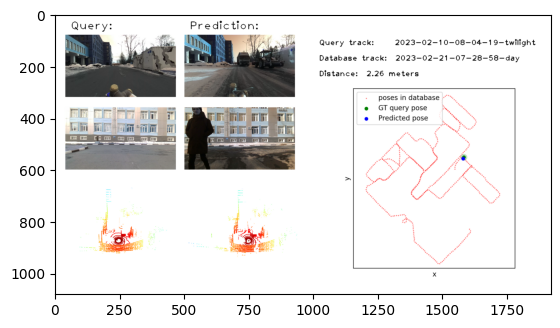

In [132]:
frame = make_frame(query_front_cam, query_back_cam, query_pc, pred_front_cam, pred_back_cam, pred_pc, prediction_map, distance=distance)
plt.imshow(frame)
cv2.imwrite("sample_baseline_result.png", frame)

In [29]:
import pandas as pd

train_df = pd.read_csv("/home/docker_hackathon/Datasets/MIPT_campus/preprocessed/splitted/train/train.csv", index_col=0)
utms = train_df[["tx", "ty"]].to_numpy()

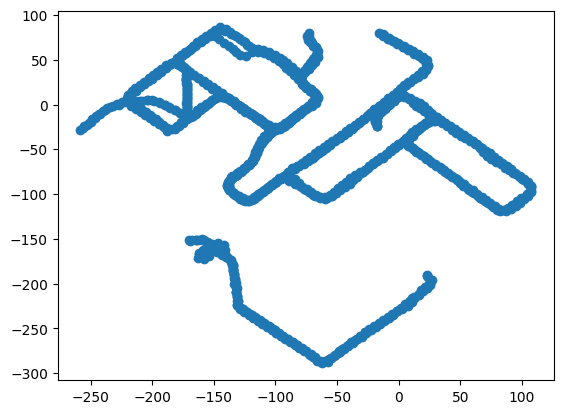

In [30]:
import matplotlib.pyplot as plt

plt.scatter(utms[:, 1], utms[:, 0])
plt.show()

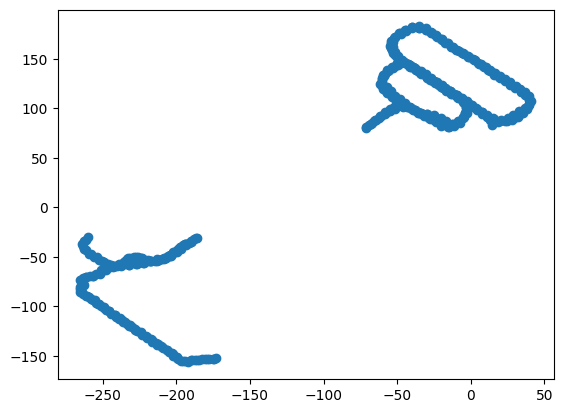

In [32]:
val_df = pd.read_csv("/home/docker_hackathon/Datasets/MIPT_campus/preprocessed/splitted/train/val.csv", index_col=0)
utms = val_df[["tx", "ty"]].to_numpy()

plt.scatter(utms[:, 1], utms[:, 0])
plt.show()